In [1]:
import numpy as np
import random

from tqdm import tqdm
from collections import Counter
from utils_import import load_data
from utils_preprocess import split_data, compute_energy_matrix_and_labels
from utils_clustering import create_cluster, cluster_mapping
from utils_test import predict_labels
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

random.seed(1337)
np.random.seed(1337)

# Asumption: all signals consist of 50k samples
n_samples = 50000
interv = 1024 # Hyperparameter 1
array_length = (n_samples // interv) - 1
n_frec_div = 32 # Hyperparameter 2

# Load data
signals_clean = load_data('../dataset/Jamming/Clean', '../dataset/Jamming/metadata.csv')
signals_narrowband = load_data('../dataset/Jamming/Narrowband', '../dataset/Jamming/metadata.csv')
signals_wideband = load_data('../dataset/Jamming/Wideband', '../dataset/Jamming/metadata.csv')

# Partition train=0.8, test=0.2
clean_train, clean_test = split_data(signals_clean, 0.8)
narrowband_train, narrowband_test = split_data(signals_narrowband, 0.8)
wideband_train, wideband_test = split_data(signals_wideband, 0.8)

train = []
train.extend(clean_train)  
train.extend(narrowband_train)  
train.extend(wideband_train) 
test = [] 
test.extend(clean_test)  
test.extend(narrowband_test) 
test.extend(wideband_test) 

print(f"Nº señales entrenamiento: {len(train)}")
print(f"Nº señales test: {len(test)}")

random.shuffle(train)
random.shuffle(test)

class_mapping = {"Clean": 0, "Narrowband Start": 1, "Narrowband Stop": 2, "Wideband Start": 3, "Wideband Stop": 4}
class_unmapping = {v:k for k,v in class_mapping.items()}


7500it [00:06, 1228.38it/s]
7500it [00:06, 1248.00it/s]
7500it [00:05, 1262.38it/s]

Nº señales entrenamiento: 18000
Nº señales test: 4500


/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/stelin41/Library/CloudStorage/OneDrive-UniversidadedeSantiagodeCompostela/usc/materias_3_1/ProyectoIntegrador/ProyectoIntegradorI/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(48, 1024)


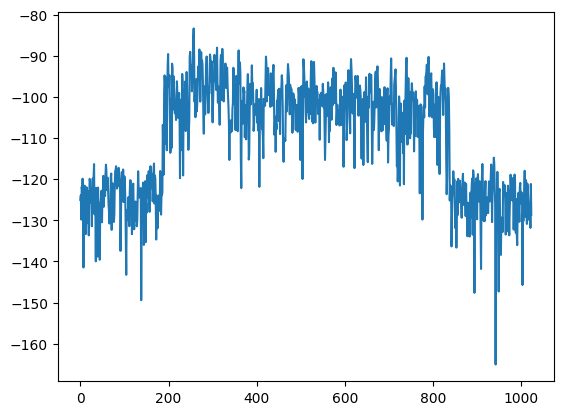

{'Data': array([-0.02951139-0.03698843j,  0.00030519-0.00030519j,
        0.00158696+0.01062044j, ..., -0.03268532+0.01327555j,
       -0.01016266+0.02133243j,  0.00833155+0.03701894j], dtype=complex64), 'Class': 'Narrowband', 'JammingStartTime': np.int64(13326), 'AveragePower_dB': np.float64(-28.87519359588623)}
(48, 1024)


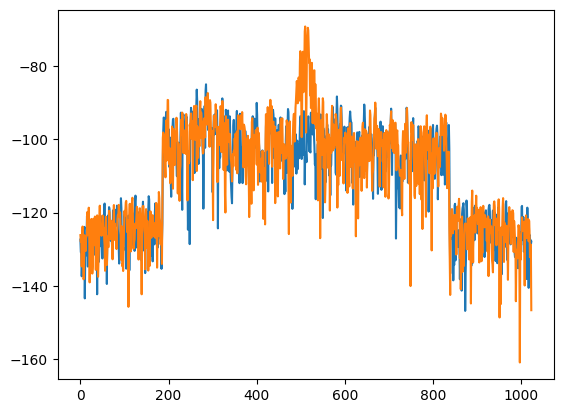

{'Data': array([ 0.06189152-0.00094607j,  0.02996917-0.01736503j,
       -0.02877895+0.00695822j, ...,  0.02069154-0.00323496j,
        0.05496382-0.00378429j,  0.00469985-0.00555437j], dtype=complex64), 'Class': 'Wideband', 'JammingStartTime': np.int64(12773), 'AveragePower_dB': np.float64(-28.82474184036255)}
(48, 1024)


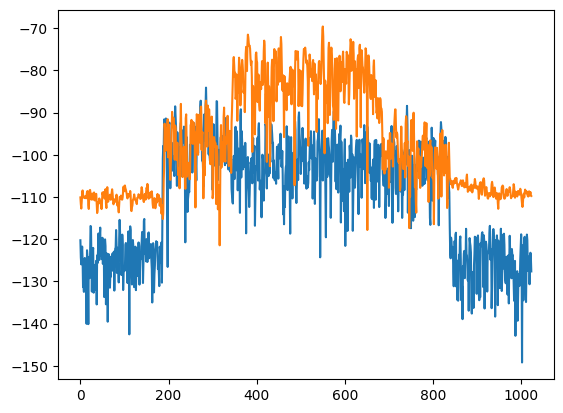

----------------------------------------------------------------------------------------------------
[[-132.83255 +0.j -126.86225 +0.j -120.010956+0.j ... -124.27451 +0.j
  -129.96368 +0.j -152.49312 +0.j]
 [-120.24972 +0.j -124.33    +0.j -125.963135+0.j ... -123.20736 +0.j
  -124.330894+0.j -127.6324  +0.j]
 [-110.09662 +0.j -111.677795+0.j -112.73477 +0.j ... -108.81985 +0.j
  -109.608376+0.j -109.74883 +0.j]]
[[-0.02093226  0.00148698 -0.03871095 -0.01464876 -0.0464496   0.01727955
   0.02048479 -0.0041203   0.00873459  0.05258286  0.00079624  0.00059813
  -0.00975289  0.00609788 -0.02499658 -0.01005171]
 [-0.26856637 -0.25184962 -0.20783862 -0.04709355  0.03837921 -0.29815152
  -0.41745988 -0.44244045 -0.43735358 -0.49089387 -0.26901338 -0.07878731
  -0.01416742 -0.30532974 -0.26865673 -0.30225652]]


In [2]:
from utils_preprocess import *
import matplotlib.pyplot as plt

d = train[0]["Data"] # Clean
f = signal_interval(d)
print(f.shape)
plt.plot(f[20])
plt.show()

d = train[1]["Data"] # Narrowband
start = train[1]['JammingStartTime']//1024
print(train[1])
f = signal_interval(d)
print(f.shape)
plt.plot(f[start-1])
plt.plot(f[start])
plt.show()


d = train[6]["Data"] # Wideband
start = train[6]['JammingStartTime']//1024
print(train[6])
f = signal_interval(d)
print(f.shape)
plt.plot(f[start-1])
plt.plot(f[start])
plt.show()

t = f[start-2:start+1]
print("-"*100)
print(t)
e=energy_arrays(t, 16)
print(e)


In [3]:
# 1) -- Train --

# Building energy arrays for each train signal (x=window samples, y=frecuency divisions z=signal)
train_energy_dif_matrix, sample_labels = compute_energy_matrix_and_labels(train, n_samples, interv, n_frec_div, class_mapping)
# Creating K-Means model based on energy arrays
cluster = create_cluster(train_energy_dif_matrix, k=5)
print(f"\n--- Centros de cluster ---\n{cluster.cluster_centers_}") 

# Mapping cluster to original classes
cluster_map = cluster_mapping(cluster.labels_, sample_labels, class_mapping)
print(f"\nMapping clusters to predominant classes: {cluster_map}")

18000it [00:57, 315.34it/s]



--- Centros de cluster ---
[[ 4.85679554e-04 -9.38876556e-04 -3.75796067e-04 -3.45765452e-04
   3.15537435e-04  1.63615095e-04 -5.40170456e-04 -6.01586526e-04
  -1.00815075e-04  2.66116071e-04 -1.75018031e-04 -3.15093413e-05
  -5.46242685e-04 -4.70758867e-05 -7.73103113e-05 -2.44194195e-01
  -2.30879038e-01 -6.65742193e-04 -2.17543975e-04 -2.38176427e-04
   1.40206602e-04  6.64226001e-04  6.18818297e-04 -3.19506502e-05
   3.94731648e-04 -6.74746049e-05 -3.74223114e-04 -6.78017532e-04
  -7.67604719e-04 -2.93510445e-04 -1.21140836e-04 -7.16894361e-04]
 [ 4.45729809e-04 -3.67689347e-05 -5.84847890e-04  3.01665306e-05
  -5.93457621e-04 -5.09843404e-04 -6.27295357e-04  2.01368320e-04
   3.83646971e-04  5.33425146e-04 -4.86935364e-04  6.90440661e-04
  -2.06993716e-04 -9.54054534e-05  7.31258950e-04  2.44997668e-01
   2.30260651e-01  1.36272262e-04  1.01404536e-03 -1.69395404e-04
   4.51619231e-05  2.68917193e-04  3.64314478e-04  4.48102195e-04
  -5.47631172e-04 -4.62534547e-04 -5.63573534e-

In [4]:
# 2) -- Test -- 

test_energy_dif_matrix, y_true = compute_energy_matrix_and_labels(test, n_samples, interv, n_frec_div, class_mapping)

y_pred = [cluster_map[label] for label in cluster.predict(test_energy_dif_matrix)]
# Nota: por el momento predice en exceso clase 1 (corregir desbalanceo, clase mayoritaria tiene muchas más ocurrencias)
print(np.bincount(y_pred))

# True signal classification
#signal_true = np.zeros(len(test), dtype=np.int8)
#for i, signal in enumerate(test):
#    signal_true[i] = class_mapping[signal["Class"]]

# Predicted signal classification
#signal_pred = predict_labels(y_pred, N=len(test), array_length=array_length)

4500it [00:14, 313.31it/s]


[1524 1490 1486 1500 1500]


In [5]:
# 3) -- Metrics --

# Accuracy
#acc = accuracy_score(signal_true, signal_pred)
#print(f"\nAccuracy: {acc}")        

# Confusion Matrix
#cm = confusion_matrix(signal_true, signal_pred)
#print(f"\nConfusion Matrix:\n{cm}")

# Classification Report
#print(f"\nClassification Report:")
#print(classification_report(signal_true, signal_pred))

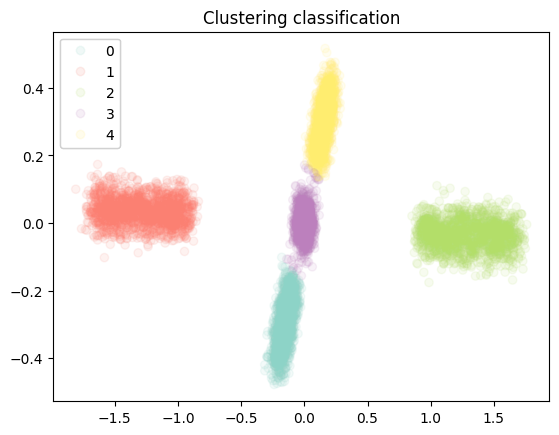

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
#from sklearn.mixture import GaussianMixture


pca = PCA(2) 
X = test_energy_dif_matrix
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
kmeans =create_cluster(X)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
#kmeans = GaussianMixture(n_components=3)
#pca_data['cluster'] = pd.Categorical(kmeans.fit_predict(X,sample_labels))

fig,ax = plt.subplots()
scatter = ax.scatter(pca_data['PC1'], pca_data['PC2'],c=pca_data['cluster'],cmap='Set3',alpha=0.1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="")
ax.add_artist(legend1)
plt.title("Clustering classification")
plt.show()

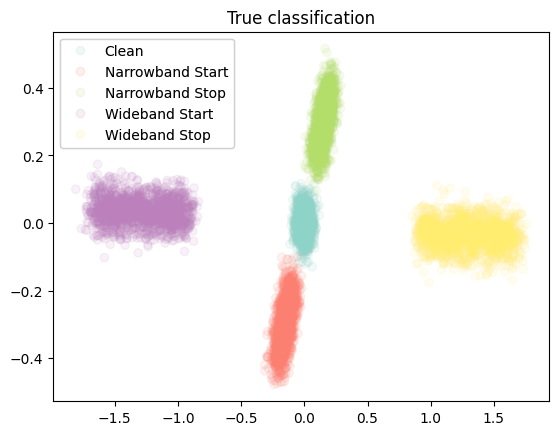

In [7]:
pca = PCA(2) 
X = test_energy_dif_matrix
pca_data = pd.DataFrame(pca.fit_transform(X),columns=['PC1','PC2']) 
pca_data['cluster'] = pd.Categorical(y_true)
#kmeans = GaussianMixture(n_components=5)
#pca_data['cluster'] = pd.Categorical(kmeans.fit_predict(X,sample_labels))

fig,ax = plt.subplots()
scatter = ax.scatter(pca_data['PC1'], pca_data['PC2'],c=pca_data['cluster'],cmap='Set3',alpha=0.1)
#legend1 = ax.legend(*scatter.legend_elements(),
legend1 = ax.legend(scatter.legend_elements()[0], class_mapping.keys(), # WARNING: labels could be wrong
                    loc="upper left", title="")
ax.add_artist(legend1)
plt.title("True classification")
plt.show()

In [8]:
np.bincount(sample_labels)

array([6000, 6000, 6000, 6000, 6000])

In [9]:
np.any(test_energy_dif_matrix < 0)

np.True_